In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import  multilabel_confusion_matrix, accuracy_score, classification_report, roc_curve, auc
from sklearn.tree import plot_tree
import seaborn as sns
import matplotlib.ticker as mtick


In [2]:
#read metabolomics, 
###*_renorm did not work well
plasma_metabolites = pd.read_csv("/Users/huananshi/Box Sync/EODF_analysis/intermediate_files/metabolomics/plasma_metabolites_log10.csv",index_col=0)
cecal_metabolites = pd.read_csv("/Users/huananshi/Box Sync/EODF_analysis/intermediate_files/metabolomics/cecal_metabolites_log10.csv",index_col=0)
plasma_metabolites_stats = pd.read_csv("/Users/huananshi/Box Sync/EODF_analysis/outputs/plasma_metabolites_stat_with_pwy_info.csv",index_col=0)
cecal_metabolites_stats = pd.read_csv("/Users/huananshi/Box Sync/EODF_analysis/outputs/cecal_metabolites_stat_with_pwy_info.csv",index_col=0)

plasma_pwy = pd.read_csv("/Users/huananshi/Box Sync/EODF_analysis/intermediate_files/metabolomics/plasma_metabolites_pwy_info.csv",index_col=0)
cecal_pwy = pd.read_csv("/Users/huananshi/Box Sync/EODF_analysis/intermediate_files/metabolomics/cecal_metabolites_pwy_info.csv",index_col=0)

In [3]:
#formating plasma data for sklearn
plasma_reads = np.array(plasma_metabolites[3:].astype(float).transpose())
plasma_metabolites_names = np.array(plasma_metabolites.index[3:])

#encoding groups
plasma_labels = np.array(plasma_metabolites.transpose()["Group"])
plasma_lb = preprocessing.LabelEncoder()
plasma_label_num = plasma_lb.fit_transform(plasma_labels)

n_plasma_samples, n_plasma_features = plasma_reads.shape
n_plasma_classes = plasma_label_num.shape[0]
print("plasma metabolomics: ",n_plasma_samples, "samples; ",n_plasma_features,"features; ",n_plasma_classes,"classes:", plasma_lb.classes_)

plasma metabolomics:  26 samples;  943 features;  26 classes: ['SHRSP Con' 'SHRSP EODF' 'WKY Con' 'WKY EODF']


In [4]:
#formating cecal data for sklearn
cecal_reads = np.array(cecal_metabolites[3:].astype(float).transpose())
cecal_metabolites_names = np.array(cecal_metabolites.index[3:])

#encoding groups
cecal_labels = np.array(cecal_metabolites.transpose()["Group"])
cecal_lb = preprocessing.LabelEncoder()
cecal_label_num = cecal_lb.fit_transform(cecal_labels)

n_cecal_samples, n_cecal_features = cecal_reads.shape
n_cecal_classes = cecal_label_num.shape[0]
print("cecal metabolomics: ",n_cecal_samples, "samples; ",n_cecal_features,"features; ",n_cecal_classes,"classes:", cecal_lb.classes_)

cecal metabolomics:  27 samples;  851 features;  27 classes: ['SHRSP Con' 'SHRSP EODF' 'WKY Con' 'WKY EODF']


In [5]:
#data sampling: split data for training and testing. 70% for training
plasma_train, plasma_test, plasma_lb_train, plasma_lb_test = train_test_split(plasma_reads,plasma_label_num,
                                                                        shuffle = True, test_size = 0.3, random_state = 41)

cecal_train, cecal_test, cecal_lb_train, cecal_lb_test = train_test_split(cecal_reads,cecal_label_num,
                                                                        shuffle = True, test_size = 0.3, random_state = 41)

In [6]:
#building random forest classifier, train/fit with train data

plasma_forest = RandomForestClassifier(random_state=1,n_estimators=3000)
plasma_classfier = plasma_forest.fit(plasma_train, plasma_lb_train)

cecal_forest = RandomForestClassifier(random_state=1,n_estimators=3000)
cecal_classfier = cecal_forest.fit(cecal_train, cecal_lb_train)


In [2]:
help(RandomForestClassifier)

Help on class RandomForestClassifier in module sklearn.ensemble._forest:

class RandomForestClassifier(ForestClassifier)
 |  RandomForestClassifier(n_estimators=100, *, criterion='gini', max_depth=None, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features='auto', max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, bootstrap=True, oob_score=False, n_jobs=None, random_state=None, verbose=0, warm_start=False, class_weight=None, ccp_alpha=0.0, max_samples=None)
 |  
 |  A random forest classifier.
 |  
 |  A random forest is a meta estimator that fits a number of decision tree
 |  classifiers on various sub-samples of the dataset and uses averaging to
 |  improve the predictive accuracy and control over-fitting.
 |  The sub-sample size is controlled with the `max_samples` parameter if
 |  `bootstrap=True` (default), otherwise the whole dataset is used to build
 |  each tree.
 |  
 |  Read more in the :ref:`User Guide <forest>`.
 |  
 |  P

In [7]:
#Model Evaluation

#confusion matrix and prediction accuracy
#calculate predicted data with test input/reads
plasma_pred = plasma_forest.predict(plasma_test)
cecal_pred = cecal_forest.predict(cecal_test)
#calculate confusion matrix 
cm_plasma = multilabel_confusion_matrix(plasma_lb_test, plasma_pred)
cm_cecal = multilabel_confusion_matrix(cecal_lb_test, cecal_pred)
print("plasma metabolomics \n", cm_plasma, "\n cecal metabolomics \n", cm_cecal)
#accuracy with test data
plasma_accuracies = accuracy_score(plasma_lb_test, plasma_pred)
cecal_accuracies = accuracy_score(cecal_lb_test, cecal_pred)
print("Model test accuracy for plasma: {0:0.2f}%.".format(plasma_accuracies*100))
print("Model test accuracy for cecal: {0:0.2f}%.".format(cecal_accuracies*100))

plasma metabolomics 
 [[[6 0]
  [0 2]]

 [[5 0]
  [0 3]]

 [[7 0]
  [0 1]]

 [[6 0]
  [0 2]]] 
 cecal metabolomics 
 [[[6 0]
  [0 3]]

 [[7 1]
  [0 1]]

 [[8 0]
  [0 1]]

 [[5 0]
  [1 3]]]
Model test accuracy for plasma: 100.00%.
Model test accuracy for cecal: 88.89%.


In [8]:
#classification reports
print("plasma metabolomics classification report \n",classification_report(plasma_lb_test, plasma_pred, target_names=plasma_lb.classes_,zero_division=0))
print("cecal metabolomics classification report \n",classification_report(cecal_lb_test, cecal_pred, target_names=cecal_lb.classes_,zero_division=0))

plasma metabolomics classification report 
               precision    recall  f1-score   support

   SHRSP Con       1.00      1.00      1.00         2
  SHRSP EODF       1.00      1.00      1.00         3
     WKY Con       1.00      1.00      1.00         1
    WKY EODF       1.00      1.00      1.00         2

    accuracy                           1.00         8
   macro avg       1.00      1.00      1.00         8
weighted avg       1.00      1.00      1.00         8

cecal metabolomics classification report 
               precision    recall  f1-score   support

   SHRSP Con       1.00      1.00      1.00         3
  SHRSP EODF       0.50      1.00      0.67         1
     WKY Con       1.00      1.00      1.00         1
    WKY EODF       1.00      0.75      0.86         4

    accuracy                           0.89         9
   macro avg       0.88      0.94      0.88         9
weighted avg       0.94      0.89      0.90         9



In [227]:
# 5 fold CV accuracy with training data
plasma_cv_accuracy = np.mean(cross_val_score(plasma_classfier, plasma_reads,plasma_label_num, cv =5))
cecal_cv_accuracy = np.mean(cross_val_score(cecal_classfier, cecal_reads,cecal_label_num, cv =5))
print("Model 5-fold CV accuracy for plasma: {0:0.2f}%.".format(plasma_cv_accuracy*100))
print("Model 5-fold CV accuracy for cecal: {0:0.2f}%.".format(cecal_cv_accuracy*100))

Model 5-fold CV accuracy for plasma: 100.00%.
Model 5-fold CV accuracy for cecal: 88.67%.


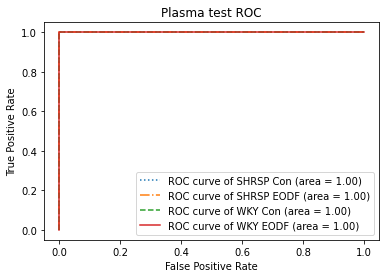

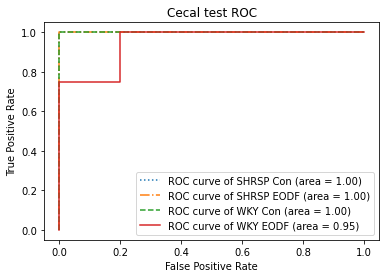

In [7]:
#ROC curves and AUC with testing data
#roc_curve only works with binary array, transform y_test to binary
label_binary = preprocessing.LabelBinarizer()
plasma_test_binary=label_binary.fit_transform(plasma_lb_test)
cecal_test_binary=label_binary.fit_transform(cecal_lb_test)
plasma_prob = plasma_classfier.predict_proba(plasma_test)
cecal_prob = cecal_classfier.predict_proba(cecal_test)

#calculate true positive rate ans false positive rate 
plasma_fpr = dict()
plasma_tpr = dict()
plasma_roc_auc = dict()

for i in range(4):
    plasma_fpr[i], plasma_tpr[i],_ = roc_curve(plasma_test_binary[:,i],plasma_prob[:,i])
    plasma_roc_auc[i] = auc(plasma_fpr[i],plasma_tpr[i])

cecal_fpr = dict()
cecal_tpr = dict()
cecal_roc_auc = dict()
for i in range(4):
    cecal_fpr[i], cecal_tpr[i],_ = roc_curve(cecal_test_binary[:,i],cecal_prob[:,i])
    cecal_roc_auc[i] = auc(cecal_fpr[i],cecal_tpr[i])
    
#plot and save ROC curve    
plasma_roc = plt.figure(0)
for i, ls in zip(range(4),[":","-.","--",'-']):
    plt.plot(plasma_fpr[i],plasma_tpr[i],linestyle = ls,label='ROC curve of {0} (area = {1:0.2f})'
             ''.format(plasma_lb.classes_[i], plasma_roc_auc[i]))
plt.legend(loc="lower right")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("Plasma test ROC")


cecal_roc = plt.figure(2)
for i, ls in zip(range(4),[":","-.","--",'-']):
    plt.plot(cecal_fpr[i],cecal_tpr[i],linestyle = ls,label='ROC curve of {0} (area = {1:0.2f})'
             ''.format(cecal_lb.classes_[i], cecal_roc_auc[i]))
plt.legend(loc="lower right")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("Cecal test ROC")

plasma_roc.savefig("/Users/huananshi/Box Sync/EODF_analysis/outputs/Plasma_RF_test_roc.png",format="png")
cecal_roc.savefig("/Users/huananshi/Box Sync/EODF_analysis/outputs/Cecal_RF_test_roc.png",format="png")


In [8]:
#get feature importances from RF
plasma_importance = pd.DataFrame(index=plasma_metabolites_names,columns=["importance"])
cecal_importance = pd.DataFrame(index=cecal_metabolites_names,columns=["importance"])
plasma_importance['importance'] = plasma_forest.feature_importances_
cecal_importance['importance'] = cecal_forest.feature_importances_
#save RF feature importances
#plasma_importance.to_csv("/Users/huananshi/Box Sync/EODF_analysis/outputs/plasma_metabolites_RF_feature_importances_accuracy_{0:0.0f}%.csv".format(plasma_accuracies*100))
#cecal_importance.to_csv("/Users/huananshi/Box Sync/EODF_analysis/outputs/cecal_metabolites_RF_feature_importances_accuracy_{0:0.0f}%.csv".format(cecal_accuracies*100))

#RF feature importances with metabolites pathway information
plasma_importance_pwy= pd.concat([plasma_pwy,plasma_importance],axis = 1)
cecal_importance_pwy = pd.concat([cecal_pwy,cecal_importance],axis = 1)
#plasma_importance_pwy.to_csv("/Users/huananshi/Box Sync/EODF_analysis/outputs/plasma_metabolites_RF_feature_importances_with_pwy_accuracy_{0:0.0f}%.csv".format(plasma_accuracies*100))
#cecal_importance_pwy.to_csv("/Users/huananshi/Box Sync/EODF_analysis/outputs/cecal_metabolites_RF_feature_importances_with_pwy_accuracy_{0:0.0f}%.csv".format(cecal_accuracies*100))

#RF feature importances groupby sub pathways
plasma_importance_subpwy = plasma_importance_pwy.groupby("SUB PATHWAY").sum()
cecal_importance_subpwy = cecal_importance_pwy.groupby("SUB PATHWAY").sum()
#plasma_importance_subpwy.to_csv("/Users/huananshi/Box Sync/EODF_analysis/outputs/plasma_metabolites_RF_feature_importances_by_subpwy_accuracy_{0:0.0f}%.csv".format(plasma_accuracies*100))
#cecal_importance_subpwy.to_csv("/Users/huananshi/Box Sync/EODF_analysis/outputs/cecal_metabolites_RF_feature_importances_by_subpwy_accuracy_{0:0.0f}%.csv".format(cecal_accuracies*100))



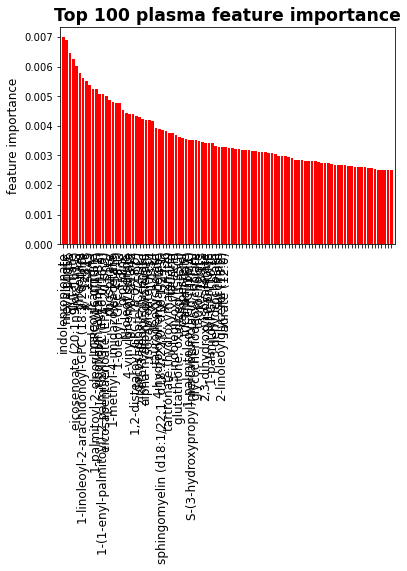

In [9]:
#Top 100 plasma metabolites importances
importances = plasma_classfier.feature_importances_
#std = np.std([tree.feature_importances_ for tree in plasma_multi_target_forest.estimators_[0].estimators_],axis =0)
indices = np.argsort(importances)[::-1]
feature_list = [plasma_metabolites_names[indices[f]] for f in range(plasma_metabolites_names.shape[0])]
plt.figure()
plt.rcParams['figure.figsize'] = [70,30]
plt.title("Top 100 plasma feature importance",fontsize="xx-large", fontweight = "bold")
plt.bar(range(100),importances[indices[0:100]],color = "r",align="center")
plt.xticks(range(100),np.array(feature_list)[indices[0:100]],rotation = 90,fontsize = "large")
plt.ylabel("feature importance",fontsize="large" )
plt.xlim([-1,100])
plt.show()


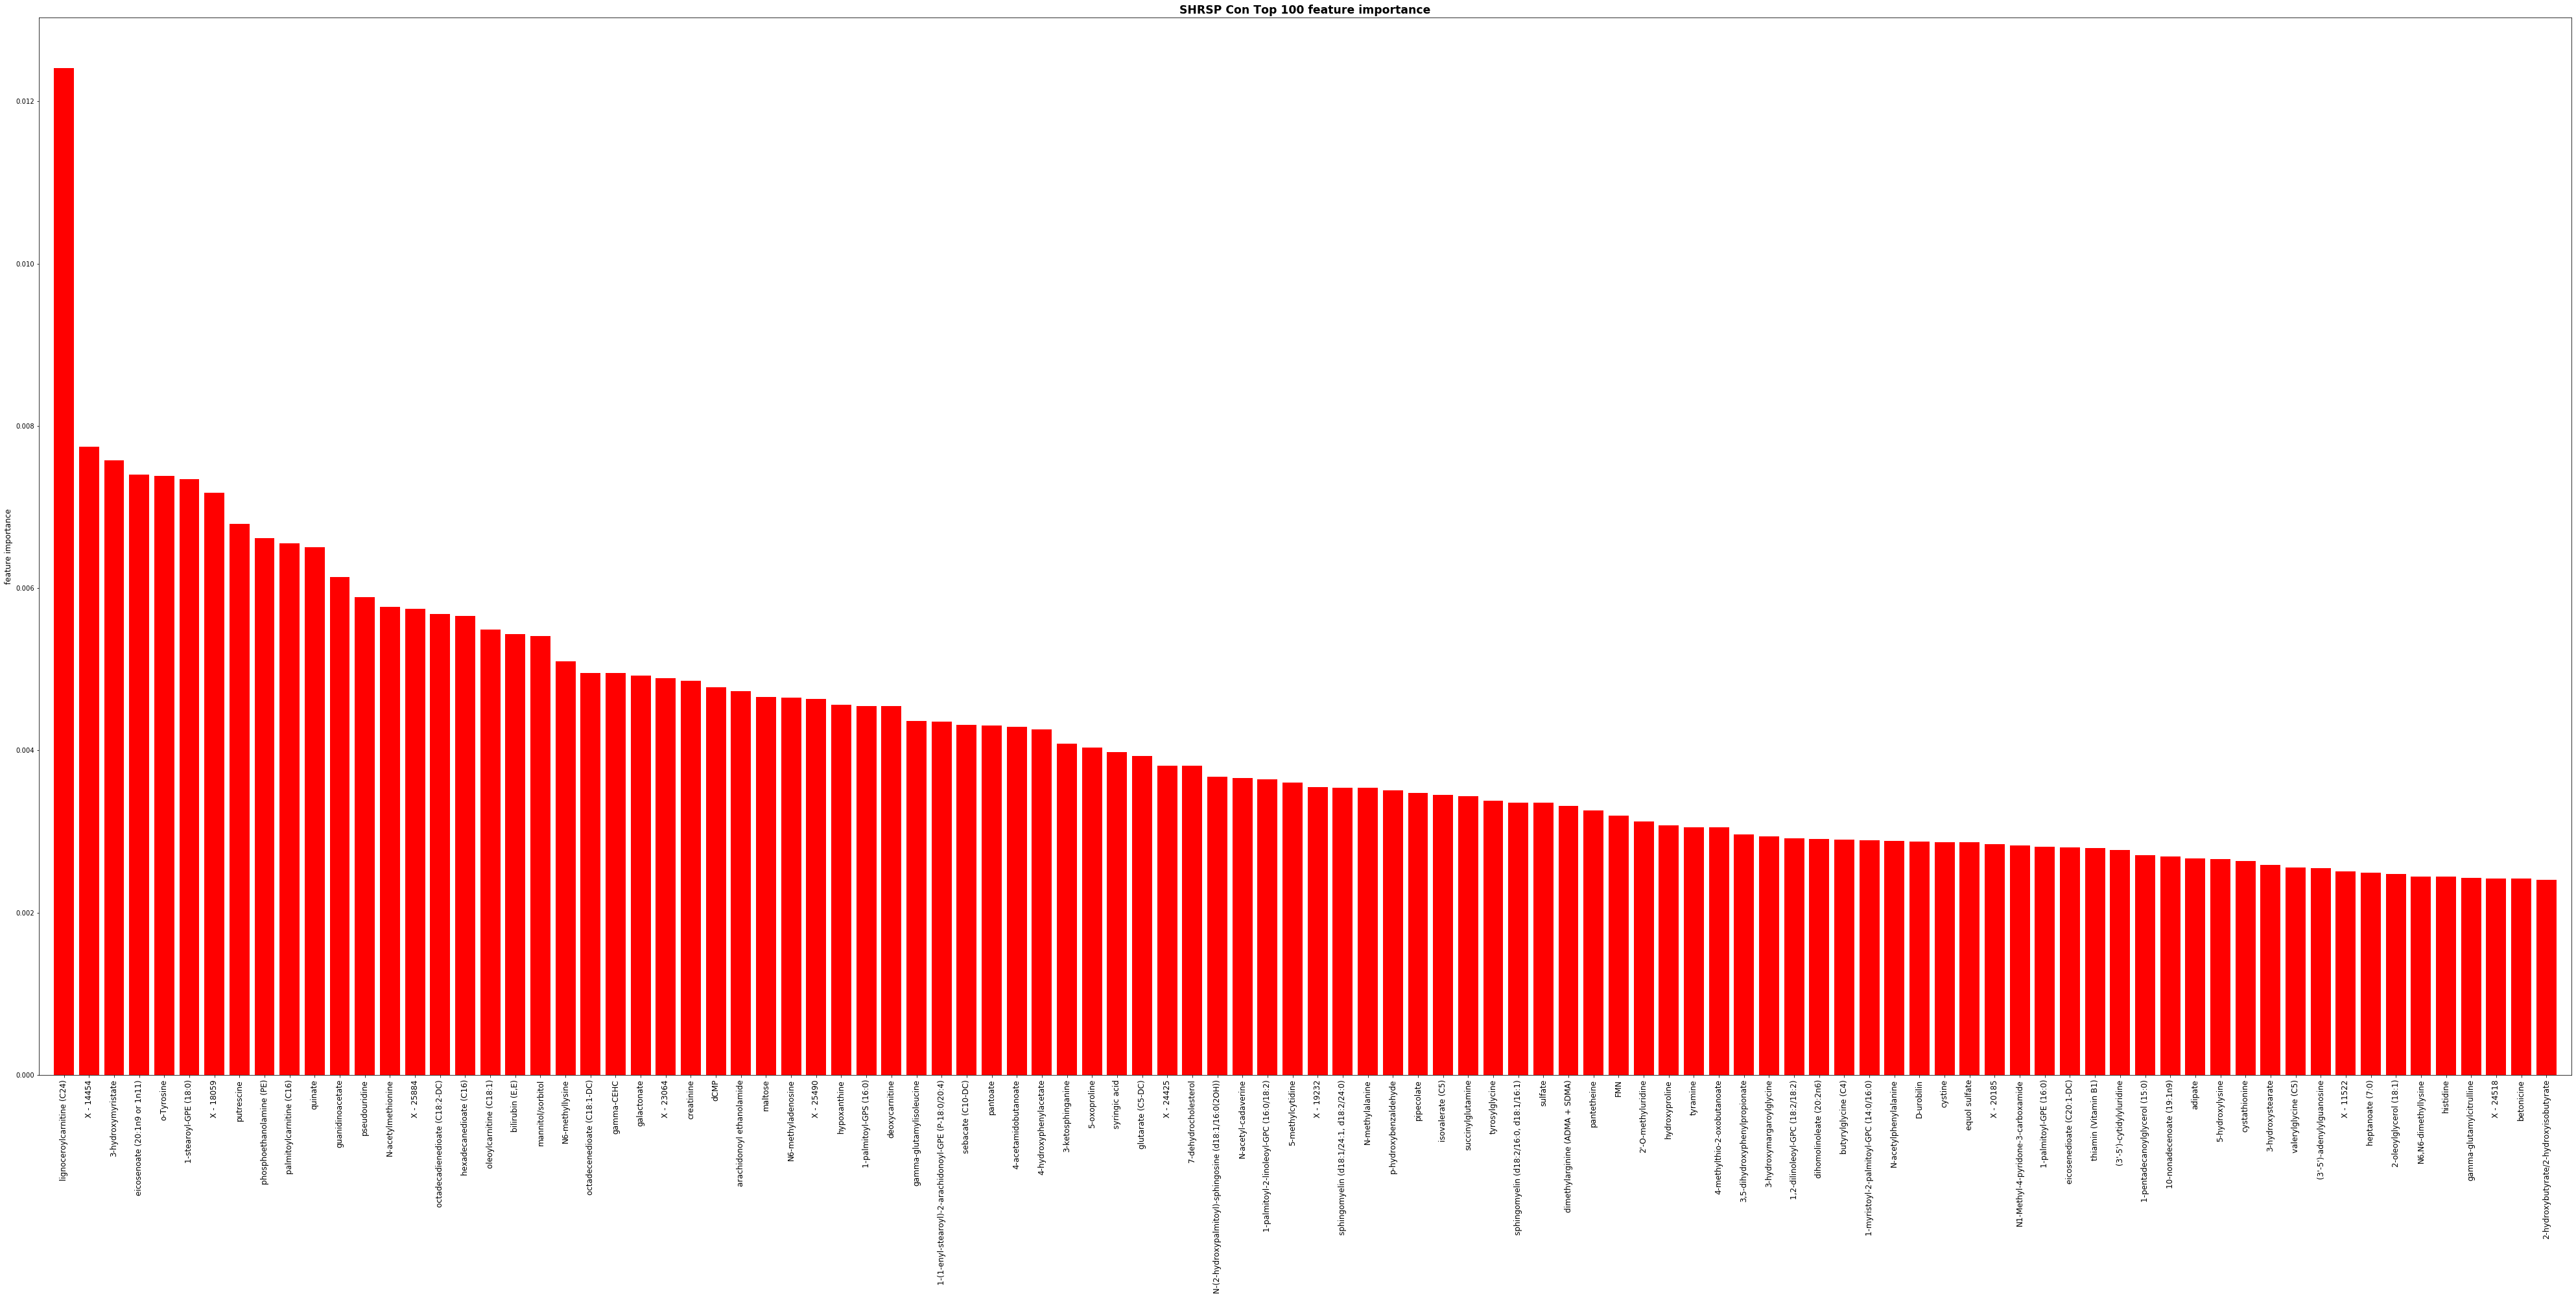

In [39]:
#Top 100 cecal metabolites importances 
importances = cecal_classfier.feature_importances_
std = np.std([tree.feature_importances_ for tree in cecal_classfier],axis =0)
indices = np.argsort(importances)[::-1]
feature_list = [cecal_metabolites_names[indices[f]] for f in range(cecal_metabolites_names.shape[0])]
plt.figure()
plt.rcParams['figure.figsize'] = [100,30]
plt.title("Top 100 cecal feature importance",fontsize="xx-large", fontweight = "bold")
plt.bar(range(100),importances[indices[0:100]],color = "r",align="center")
plt.xticks(range(100),np.array(feature_list)[indices[0:100]],rotation = 90,fontsize = "large")
plt.ylabel("feature importance",fontsize="large" )
plt.xlim([-1,100])
plt.show()





In [158]:
#features that are significate different by anova and are all important 
plasma_sig_index = plasma_metabolites_stats.index[plasma_metabolites_stats[plasma_metabolites_stats[["p_interaction","p_genotype","p_treatment"]]<=0.05].any(axis =1)].tolist()
cecal_sig_index = cecal_metabolites_stats.index[cecal_metabolites_stats[cecal_metabolites_stats[["p_interaction","p_genotype","p_treatment"]]<=0.05].any(axis =1)].tolist()
plasma_importance_pwy_sig = plasma_importance_pwy.loc[plasma_sig_index]
cecal_importance_pwy_sig = cecal_importance_pwy.loc[cecal_sig_index]

plasma_sig_important_index=plasma_importance_pwy_sig.index[plasma_importance_pwy_sig[plasma_importance_pwy_sig!=0].any(axis=1)].tolist()
cecal_sig_important_index=cecal_importance_pwy_sig.index[cecal_importance_pwy_sig[cecal_importance_pwy_sig!=0].any(axis=1)].tolist()

plasma_importance_pwy_sig_important = plasma_importance_pwy.loc[plasma_sig_important_index]
cecal_importance_pwy_sig_important = cecal_importance_pwy.loc[cecal_sig_important_index]
plasma_importance_subpwy_sig = plasma_importance_pwy_sig_important.groupby("SUB PATHWAY").sum()
cecal_importance_subpwy_sig = cecal_importance_pwy_sig_important.groupby("SUB PATHWAY").sum()
plasma_importance_subpwy_sig = plasma_importance_subpwy_sig.sort_values(by = ["importance"],ascending = False)
cecal_importance_subpwy_sig = cecal_importance_subpwy_sig.sort_values(by = ["importance"],ascending = False)



In [111]:
plasma_importace_pwy_sig_important_p_value = pd.concat([plasma_importance_pwy_sig_important,plasma_metabolites_stats.loc[plasma_importance_pwy_sig_important.index]],axis=1)
cecal_importace_pwy_sig_important_p_value = pd.concat([cecal_importance_pwy_sig_important,cecal_metabolites_stats.loc[cecal_importance_pwy_sig_important.index]],axis=1)
plasma_importace_pwy_sig_important_p_value.to_csv('/Users/huananshi/Box Sync/EODF_analysis/outputs/plasma_metabolites_RF_with_pwy_ANOVA_filtered.csv')
cecal_importace_pwy_sig_important_p_value.to_csv('/Users/huananshi/Box Sync/EODF_analysis/outputs/cecal_metabolites_RF_with_pwy_ANOVA_filtered.csv')







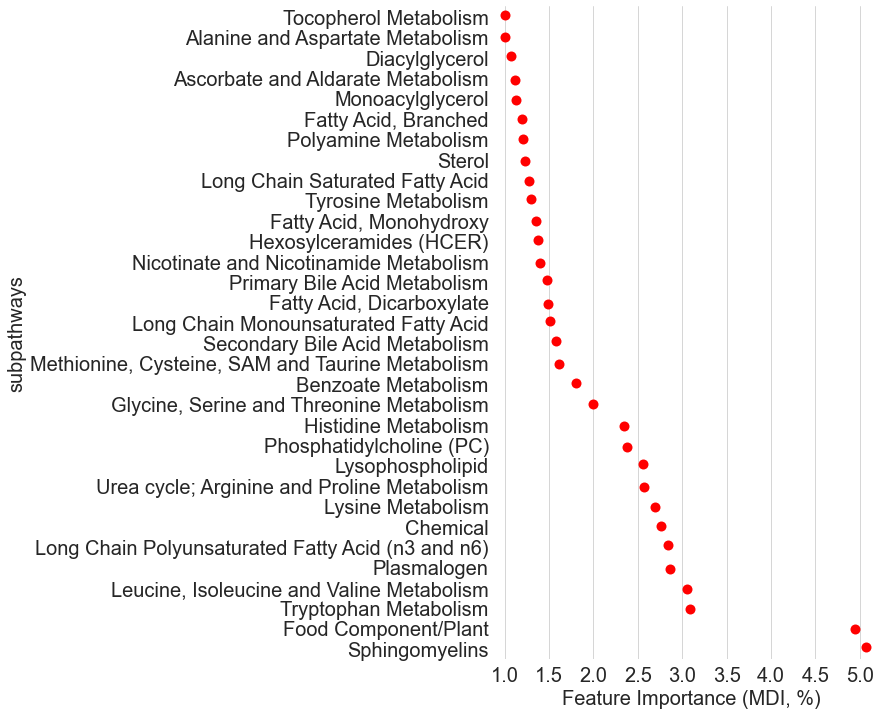

In [175]:
x = plasma_importance_subpwy_sig[plasma_importance_subpwy_sig.importance>0.01].sort_values('importance',ascending=True)
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = [7,12]
ax = sns.stripplot(x=x.importance*100,y=x.index,color='red',size=10)
ax.set_xlabel('Feature Importance (MDI, %)',fontsize=20)
sns.despine(left=True,right=True,top=True,bottom=True)
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)

plt.ylabel('subpathways',fontsize=20)
plt.xlim([0.9,5.3])
plasma_subpwy_fig=ax.get_figure()
plasma_subpwy_fig.savefig("/Users/huananshi/Box Sync/EODF_analysis/outputs/plasma_metabolites_RF_feature_importances_by_subpwy_stripplot.svg", format= "svg")


<Figure size 504x864 with 0 Axes>

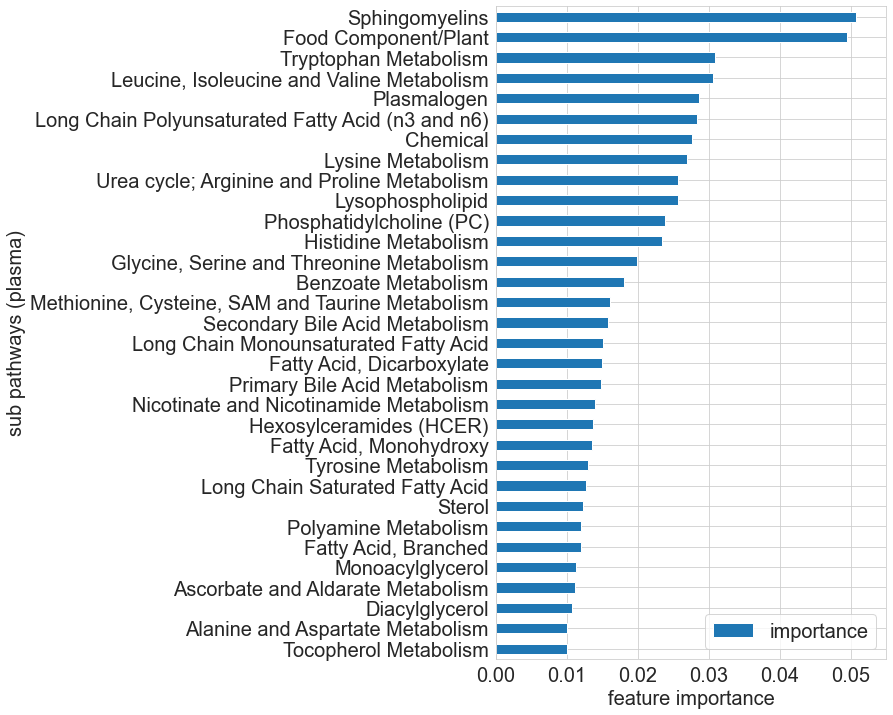

In [174]:
#plot subpathway importances (with significant features)
plasma_subpwy_fig = plt.figure()
plt.rcParams['figure.figsize'] = [10,10]
plasma_subpwy_ax = plasma_importance_subpwy_sig[plasma_importance_subpwy_sig.importance>0.01].sort_values('importance',ascending=True).plot(kind='barh')
plasma_subpwy_fig = plasma_subpwy_ax.get_figure()
plt.yticks(range(32),fontsize = 20)
plt.ylabel("sub pathways (plasma)", fontsize = 20)
plt.xticks(fontsize = 20)
plt.xlabel("feature importance",fontsize=20)
plt.xlim([0,0.055])
#plt.xscale('log',subsx=[0,2,4])
plt.legend(fontsize = 20)
#plasma_subpwy_fig.savefig("/Users/huananshi/Box Sync/EODF_analysis/outputs/plasma_metabolites_RF_feature_importances_by_subpwy.eps", format= "eps")
plasma_subpwy_fig.savefig("/Users/huananshi/Box Sync/EODF_analysis/outputs/plasma_metabolites_RF_feature_importances_by_subpwy.svg", format= "svg")
                                                  

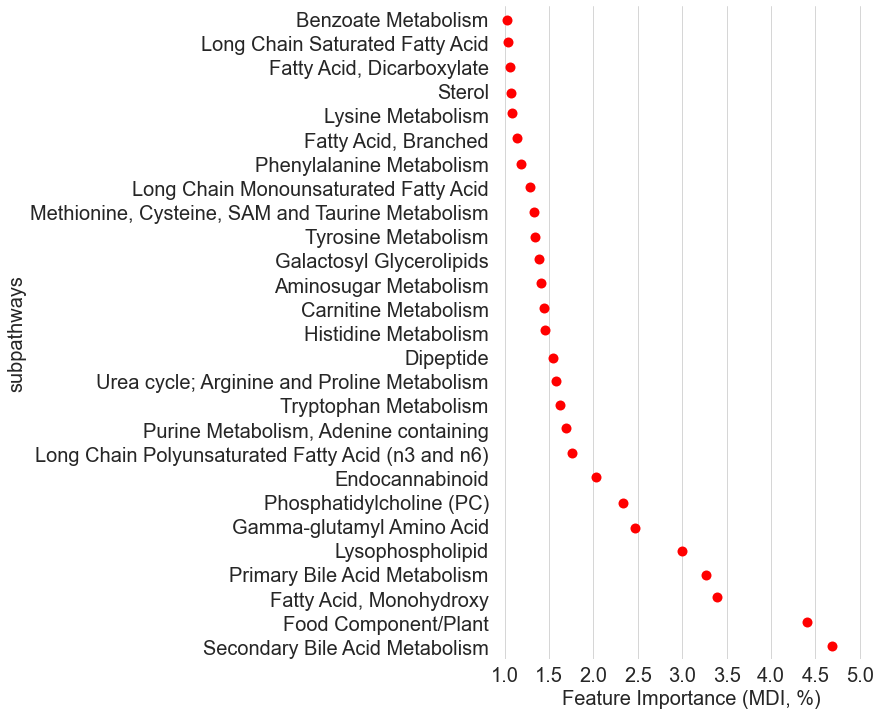

In [173]:
y = cecal_importance_subpwy_sig[cecal_importance_subpwy_sig.importance>0.01].sort_values('importance',ascending=True)
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = [7,12]
ax = sns.stripplot(x=y.importance*100,y=y.index,color='red',size=10)
ax.set_xlabel('Feature Importance (MDI, %)',fontsize=20)
sns.despine(left=True,right=True,top=True,bottom=True)
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)

plt.ylabel('subpathways',fontsize=20)
plt.xlim([0.9,5.3])
cecal_subpwy_fig=ax.get_figure()
cecal_subpwy_fig.savefig("/Users/huananshi/Box Sync/EODF_analysis/outputs/cecal_metabolites_RF_feature_importances_by_subpwy_stripplot.svg", format= "svg")


<Figure size 720x720 with 0 Axes>

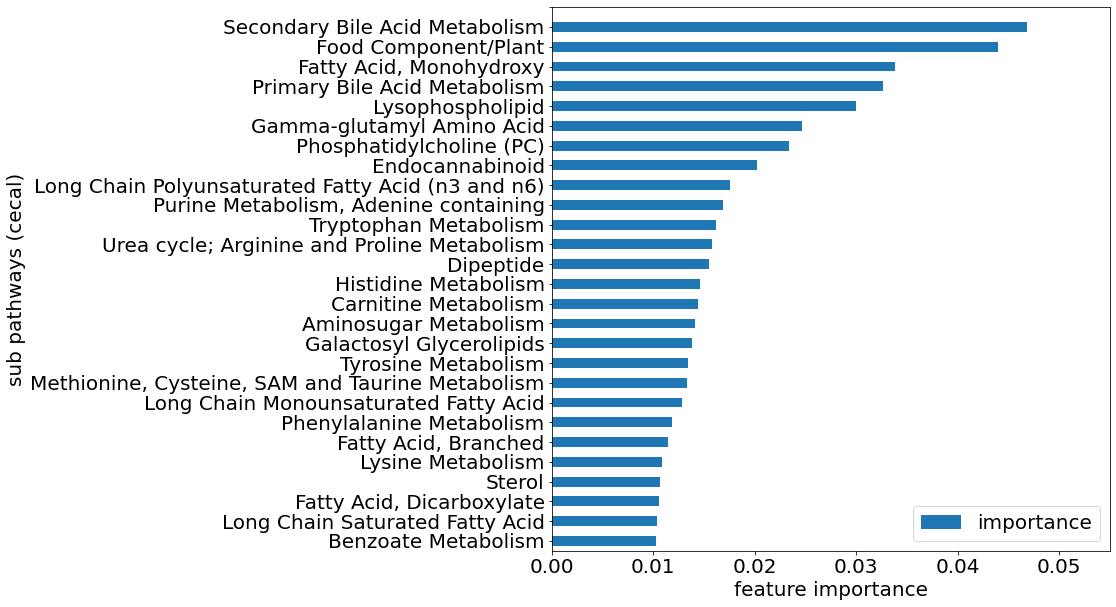

In [85]:
cecal_subpwy_fig = plt.figure()
plt.rcParams['figure.figsize'] = [10,10]
cecal_subpwy_ax = cecal_importance_subpwy_sig[cecal_importance_subpwy_sig.importance>0.01].sort_values('importance',ascending=True).plot(kind = "barh")
cecal_subpwy_fig = cecal_subpwy_ax.get_figure()
plt.yticks(range(28),fontsize = 20)
plt.ylabel("sub pathways (cecal)", fontsize = 20)
plt.xticks(fontsize = 20)
plt.xlabel("feature importance",fontsize=20)
plt.legend(fontsize = 20)
plt.xlim([0,0.055])
#plt.xscale('log',subsx=[0,2,4])
#cecal_subpwy_fig.savefig("/Users/huananshi/Box Sync/EODF_analysis/outputs/cecal_metabolites_RF_feature_importances_by_subpwy.eps", format= "eps")
cecal_subpwy_fig.savefig("/Users/huananshi/Box Sync/EODF_analysis/outputs/cecal_metabolites_RF_feature_importances_by_subpwy.svg", format= "svg")
                                                  

In [69]:
#calculate feature importance by classes
def class_feature_importance(X, Y, feature_importances):
    N, M = X.shape
    X = preprocessing.scale(X)

    out = {}
    for c in set(Y):
        out[c] = dict(
            zip(range(M), np.mean(X[Y==c, :], axis=0)*feature_importances)
        )

    return out

In [103]:
#calculate feature importance by classes
plasma_importance_by_class = class_feature_importance(plasma_reads, plasma_labels, plasma_classfier.feature_importances_)
cecal_importance_by_class = class_feature_importance(cecal_reads, cecal_labels, cecal_classfier.feature_importances_)
plasma_importance_by_class = pd.DataFrame(plasma_importance_by_class)
plasma_importance_by_class.index = plasma_metabolites_names
cecal_importance_by_class = pd.DataFrame(cecal_importance_by_class)
cecal_importance_by_class.index = cecal_metabolites_names
plasma_importance_by_class.to_csv(
    "/Users/huananshi/Box Sync/EODF_analysis/outputs/plasma_metabolites_RF_feature_importances_by_class_accuracy_{0:0.0f}%.csv"
    .format(plasma_accuracies*100))

cecal_importance_by_class.to_csv(
    "/Users/huananshi/Box Sync/EODF_analysis/outputs/cecal_metabolites_RF_feature_importances_by_class_accuracy_{0:0.0f}%.csv"
    .format(cecal_accuracies*100))

#RF feature importance_by_class with metabolites pathway information
plasma_importance_by_class_pwy= pd.concat([plasma_pwy,plasma_importance_by_class],axis = 1)
cecal_importance_by_class_pwy = pd.concat([cecal_pwy,cecal_importance_by_class],axis = 1)
plasma_importance_by_class_pwy.to_csv("/Users/huananshi/Box Sync/EODF_analysis/outputs/plasma_metabolites_RF_feature_importance_by_classs_with_pwy_accuracy_{0:0.0f}%.csv".format(plasma_accuracies*100))
cecal_importance_by_class_pwy.to_csv("/Users/huananshi/Box Sync/EODF_analysis/outputs/cecal_metabolites_RF_feature_importance_by_classs_with_pwy_accuracy_{0:0.0f}%.csv".format(cecal_accuracies*100))

#RF feature importance_by_class groupby sub pathways
plasma_importance_by_class_subpwy = plasma_importance_by_class_pwy.groupby("SUB PATHWAY").sum()
cecal_importance_by_class_subpwy = cecal_importance_by_class_pwy.groupby("SUB PATHWAY").sum()
plasma_importance_by_class_subpwy.to_csv("/Users/huananshi/Box Sync/EODF_analysis/outputs/plasma_metabolites_RF_feature_importance_by_classs_by_subpwy_accuracy_{0:0.0f}%.csv".format(plasma_accuracies*100))
cecal_importance_by_class_subpwy.to_csv("/Users/huananshi/Box Sync/EODF_analysis/outputs/cecal_metabolites_RF_feature_importance_by_classs_by_subpwy_accuracy_{0:0.0f}%.csv".format(cecal_accuracies*100))



[Text(1562.4, 1426.95, 'X[795] <= -1.064\ngini = 0.741\nsamples = 12\nvalue = [6, 4, 4, 4]\nclass = SHRSP Con'),
 Text(781.2, 1019.25, 'gini = 0.0\nsamples = 3\nvalue = [6, 0, 0, 0]\nclass = SHRSP Con'),
 Text(2343.6000000000004, 1019.25, 'X[412] <= 0.481\ngini = 0.667\nsamples = 9\nvalue = [0, 4, 4, 4]\nclass = SHRSP EODF'),
 Text(1562.4, 611.55, 'X[684] <= -0.082\ngini = 0.5\nsamples = 7\nvalue = [0, 0, 4, 4]\nclass = WKY Con'),
 Text(781.2, 203.8499999999999, 'gini = 0.0\nsamples = 3\nvalue = [0, 0, 0, 4]\nclass = WKY EODF'),
 Text(2343.6000000000004, 203.8499999999999, 'gini = 0.0\nsamples = 4\nvalue = [0, 0, 4, 0]\nclass = WKY Con'),
 Text(3124.8, 611.55, 'gini = 0.0\nsamples = 2\nvalue = [0, 4, 0, 0]\nclass = SHRSP EODF')]

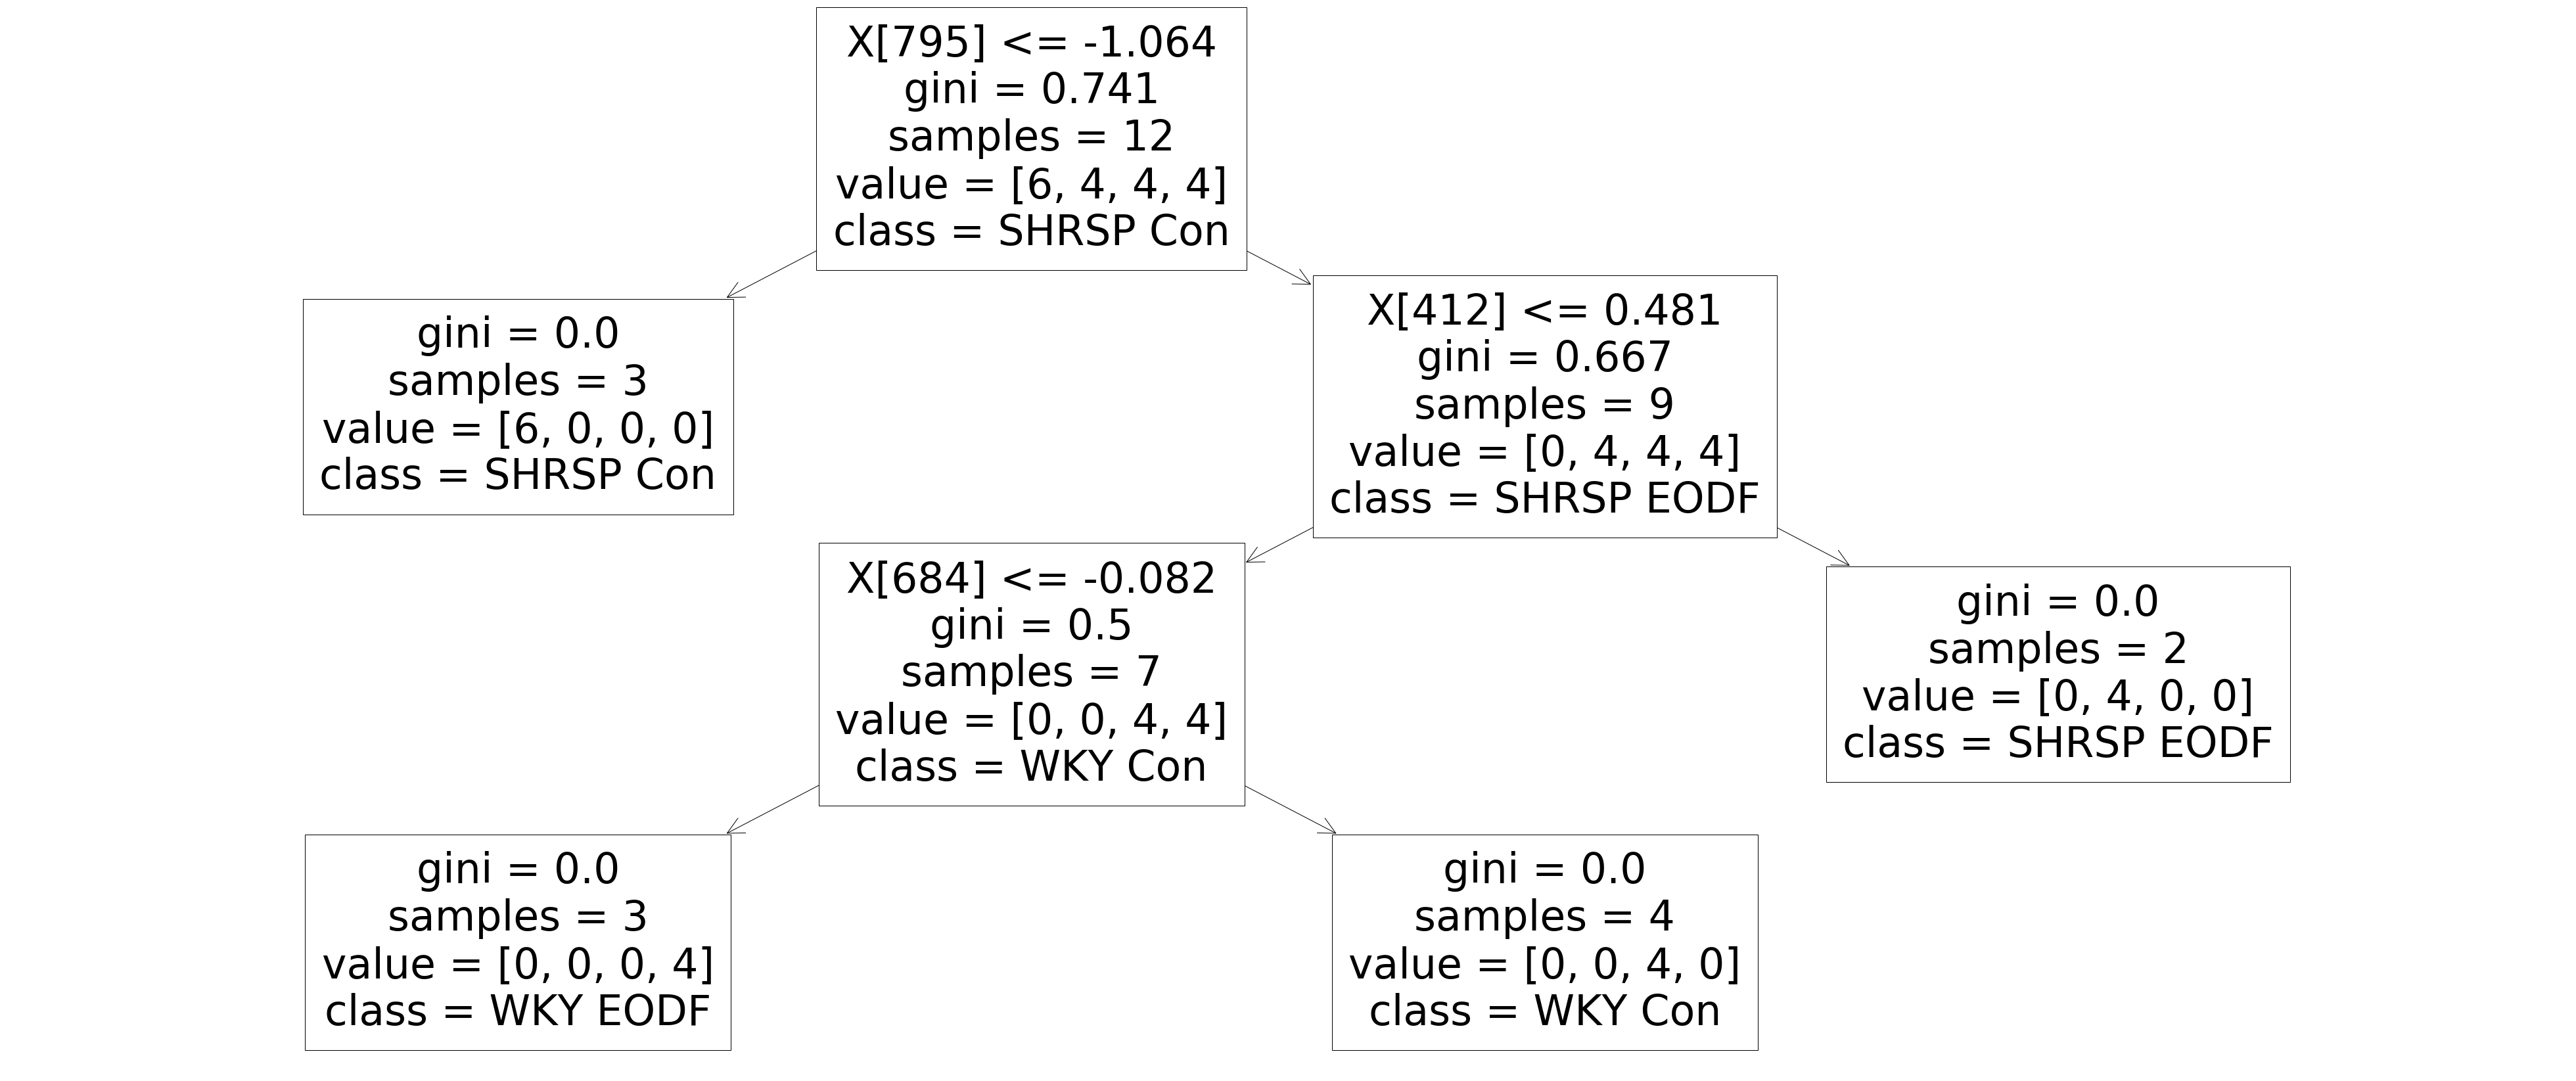

In [36]:
#example of plot tree

plot_tree(cecal_classfier.estimators_[0], class_names=cecal_lb.classes_)

